# General

---

In [530]:
# data handling 
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import math 

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns 

# mapping 
import descartes 
import geopandas as gpd
from shapely.geometry import Point, Polygon

# sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# pytorch

# Data Notes  
---  

Files (by fishing gear types):  
1. Drifting longlines vessels
2. Fixed gear vessels
3. Pole and line vessels
4. Purse Seines vessels
5. Trawlers vessels
6. Trollers vessels
7. Vessels with unknown geartypes  

CVS Table Schema:
* mmsi: anonymized vessel identifier
* timestamp: unix timestamp 
* distance_from_shore: distance from shore in meters 
* distance_from_port: distance from port in meters
* speed: vessel speed in knots
* course: vessel's course over ground (represented in degrees)
* lat: latitude in decimal degrees 
* lon: longitude in decimal degrees
* is_fishing: lable indicating fishing activity
  * 0 = not fishing
  * \>0 = fishing; data values between 0 and 1 indicate the average score for the position if scored by multiple people 
  * -1 = no data  
* source: the training data batch; data was prepared by GFW, Dalhousie, and a crowd sourcing campaign (false positives are marked as false_positives)


In [410]:
# filepaths 
drifting_longlines_file = './data/drifting_longlines.csv'
fixed_gear_file = './data/fixed_gear.csv'
pole_and_line_file = './data/pole_and_line.csv'
purse_seines_file = './data/purse_seines.csv'
trawlers_file = './data/trawlers.csv'
trollers_file = './data/trollers.csv'
unknown_file = './data/unknown.csv'

# for mapping vessel paths later 
ocean_map = gpd.read_file('./mapping/world_map/ne_50m_ocean.shp')
south_atlantic = gpd.read_file('./mapping/south_atlantic/iho.shp')
bornholm = gpd.read_file('./mapping/bornholm/europeislands.shp')
arrecife = gpd.read_file('./mapping/north_atlantic/iho.shp')
phillippine_sea = gpd.read_file('./mapping/phillippine_sea/iho.shp')
north_pacific = gpd.read_file('./mapping/north_pacific/eez_iho.shp')
crs = {'init': 'epsg:4326'}

# Exploratory Analysis / Initial Data Wrangling on Separated Datasets 
---

## Drifting Longlines    
A drifting longline consists of a mainline kept near the surface or at a certain depth by means of regularly spaced floats and with relatively long snoods with baited hooks, evenly spaced on the mainline. Drifting longlines may be of considerable length. Some drifting longlines are set vertically, each line hanging from a float at the surface. (Source: [FAO Drifting Longlines](https://www.fao.org/fishery/en/geartype/233/en))


In [411]:
# read in data from the drifting long lines vessels file 
driftingLongLinesDF = pd.read_csv(drifting_longlines_file)

# peak at the data 
driftingLongLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner


In [412]:
# check data characteristics 
driftingLongLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.396873e+07,1.396873e+07,1.396873e+07,1.396873e+07,1.396863e+07,1.396863e+07,1.396873e+07,1.396873e+07,1.396873e+07
mean,1.293850e+14,1.434290e+09,5.845311e+05,7.897505e+05,5.464779e+00,1.814876e+02,-8.997629e+00,3.758693e+00,-9.743015e-01
std,7.887357e+13,3.984275e+07,5.420068e+05,6.915438e+05,4.043567e+00,1.050503e+02,2.439311e+01,1.095971e+02,2.119947e-01
min,5.601266e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.519017e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.410706e+09,1.019092e+05,2.130206e+05,2.100000e+00,9.070000e+01,-2.601550e+01,-8.808668e+01,-1.000000e+00
50%,1.184859e+14,1.447302e+09,4.576393e+05,6.375249e+05,5.500000e+00,1.811000e+02,-1.497954e+01,-1.716495e+00,-1.000000e+00
75%,1.980758e+14,1.466506e+09,9.603664e+05,1.210432e+06,8.500000e+00,2.711000e+02,4.485790e+00,1.009811e+02,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,7.181037e+06,1.023000e+02,5.110000e+02,8.333266e+01,1.799938e+02,1.000000e+00


Many records with course values of 511, which is larger than 360 degrees. That represents not available data according to the [US Coast Guard Class A AIS Position Report Documentation](https://www.navcen.uscg.gov/?pageName=AISMessagesA).

In [413]:
# data shape 
driftingLongLinesDF.shape

(13968727, 10)

In [414]:
# drop rows without data for is_fishing
driftingLongLinesDF = driftingLongLinesDF[driftingLongLinesDF['is_fishing'] != -1]
driftingLongLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [415]:
# recheck data shape 
driftingLongLinesDF.shape

(219741, 10)

In [416]:
# check label distribution
driftingLongLinesDF['is_fishing'].value_counts()

1.000000    138163
0.000000     79574
0.666667      1076
0.333333       809
0.750000       110
0.250000         9
Name: is_fishing, dtype: int64

In [417]:
# recheck data characteristics after dropping rows missing is_fishing data 
driftingLongLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,2.197410e+05,2.197410e+05,2.197410e+05,2.197410e+05,219741.000000,219741.000000,219741.000000,219741.000000,219741.000000
mean,1.368067e+14,1.413013e+09,5.113833e+05,7.021433e+05,5.687254,181.330646,-8.010195,4.203933,0.633631
std,8.173824e+13,1.594068e+07,4.882178e+05,6.183033e+05,3.787542,103.866320,23.478505,110.809452,0.479725
min,5.601266e+12,1.338572e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-45.302502,-179.999115,0.000000
25%,6.260384e+13,1.407986e+09,9.338936e+04,1.684358e+05,2.600000,91.699997,-23.396667,-79.919830,0.000000
50%,1.220965e+14,1.411405e+09,4.179383e+05,5.699421e+05,5.700000,179.800003,-15.034370,2.768880,1.000000
75%,2.089256e+14,1.418502e+09,7.719319e+05,1.115062e+06,8.700000,271.399994,3.925500,73.103127,1.000000
max,2.812058e+14,1.451623e+09,2.185458e+06,3.117979e+06,102.300003,360.000000,73.066498,179.991486,1.000000


In [418]:
# check for null values
driftingLongLinesDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [419]:
# reformat unix timestamps into datetime
driftingLongLinesFormattedTimestamps = pd.to_datetime(driftingLongLinesDF['timestamp'], unit = 's')
driftingLongLinesDF.insert(2, 'timestamp_reformat', driftingLongLinesFormattedTimestamps)
driftingLongLinesDF.head() 

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [420]:
# add separate month, day of the week, year, and hour columns derived from timstamps
driftingLongLinesDF.insert(3, 'year', driftingLongLinesDF['timestamp_reformat'].dt.year)
# round to closest hour 
driftingLongLinesDF.insert(4, 'hour', driftingLongLinesDF['timestamp_reformat'].dt.round('H').dt.hour)
driftingLongLinesDF.insert(5, 'day_of_week', driftingLongLinesDF['timestamp_reformat'].dt.day_name())
driftingLongLinesDF.insert(6, 'month', driftingLongLinesDF['timestamp_reformat'].dt.month_name())

driftingLongLinesDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,Saturday,June,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,Tuesday,June,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,2012,7,Thursday,August,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,2012,5,Friday,August,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,2012,6,Wednesday,September,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [421]:
# count the unique mmsi's
len(pd.unique(driftingLongLinesDF['mmsi']))

110

To visualize the data, going to group records by the vessel MMSI's and plot one vessel's path on a map. Start by grouping the data, grabbing the first vessel's records, and then converting data into a GeoDataFrame. Then, plot the path using shape files in the mapping folder. 

In [422]:
# group the drifting long line vessels by their mmsi's 
driftingLongLinesMMSIGroups = driftingLongLinesDF.sort_values(['mmsi', 'timestamp_reformat']).groupby('mmsi')

# peak at first 3 rows in each resulting group 
driftingLongLinesMMSIGroups.head(3)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
1137687,5.601266e+12,1.420091e+09,2015-01-01 05:50:25,2015,6,Thursday,January,590250.687500,1.802076e+06,0.2,1.800000,-22.851770,-24.182766,1.0,gfw
1137704,5.601266e+12,1.420102e+09,2015-01-01 08:45:27,2015,9,Thursday,January,573515.375000,1.787757e+06,4.0,321.899994,-22.749702,-24.293646,1.0,gfw
1137705,5.601266e+12,1.420102e+09,2015-01-01 08:46:27,2015,9,Thursday,January,573515.375000,1.787757e+06,3.7,322.500000,-22.748981,-24.294298,1.0,gfw
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,Saturday,June,111123.328125,1.475938e+05,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,Tuesday,June,329078.531250,3.623638e+05,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693665,2.810605e+14,1.348942e+09,2012-09-29 17:59:48,2012,18,Saturday,September,26869.398438,2.183819e+05,0.3,158.899994,47.763962,139.535767,0.0,dalhousie_longliner
694325,2.810605e+14,1.359740e+09,2013-02-01 17:25:39,2013,17,Friday,February,0.000000,2.942716e+04,0.0,226.899994,42.826355,132.418411,0.0,dalhousie_longliner
13863613,2.812058e+14,1.402897e+09,2014-06-16 05:43:22,2014,6,Monday,June,526676.687500,7.122669e+05,5.9,157.699997,-6.458367,-28.446316,1.0,crowd_sourced
13863614,2.812058e+14,1.402904e+09,2014-06-16 07:34:23,2014,8,Monday,June,548603.000000,7.260848e+05,11.3,136.000000,-6.614067,-28.313932,1.0,crowd_sourced


In [423]:
# plot the ship course of the first drifting long line vessel
# get the first vessel data  
driftingLongLineVesselPlotDF = driftingLongLinesMMSIGroups.get_group(list(driftingLongLinesMMSIGroups.groups.keys())[0])

# convert longitude and latitude to Points so we can convert pandas dataframe to GeoDataFrame 
dLLPoints = [Point(xy) for xy in zip(driftingLongLineVesselPlotDF['lon'], driftingLongLineVesselPlotDF['lat'])]

# create GeoDataFrame 
dLLGeoDF = gpd.GeoDataFrame(driftingLongLineVesselPlotDF, crs = crs, geometry = dLLPoints)
dLLGeoDF.head()

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,geometry
1137687,5.601266e+12,1.420091e+09,2015-01-01 05:50:25,2015,6,Thursday,January,590250.6875,1802075.875,0.2,1.800000,-22.851770,-24.182766,1.0,gfw,POINT (-24.18277 -22.85177)
1137704,5.601266e+12,1.420102e+09,2015-01-01 08:45:27,2015,9,Thursday,January,573515.3750,1787757.000,4.0,321.899994,-22.749702,-24.293646,1.0,gfw,POINT (-24.29365 -22.74970)
1137705,5.601266e+12,1.420102e+09,2015-01-01 08:46:27,2015,9,Thursday,January,573515.3750,1787757.000,3.7,322.500000,-22.748981,-24.294298,1.0,gfw,POINT (-24.29430 -22.74898)
1137706,5.601266e+12,1.420102e+09,2015-01-01 08:52:15,2015,9,Thursday,January,573045.2500,1787563.750,3.1,334.700012,-22.742298,-24.298233,1.0,gfw,POINT (-24.29823 -22.74230)
1137707,5.601266e+12,1.420103e+09,2015-01-01 09:05:26,2015,9,Thursday,January,572576.5000,1787371.000,4.6,0.000000,-22.734077,-24.300257,1.0,gfw,POINT (-24.30026 -22.73408)


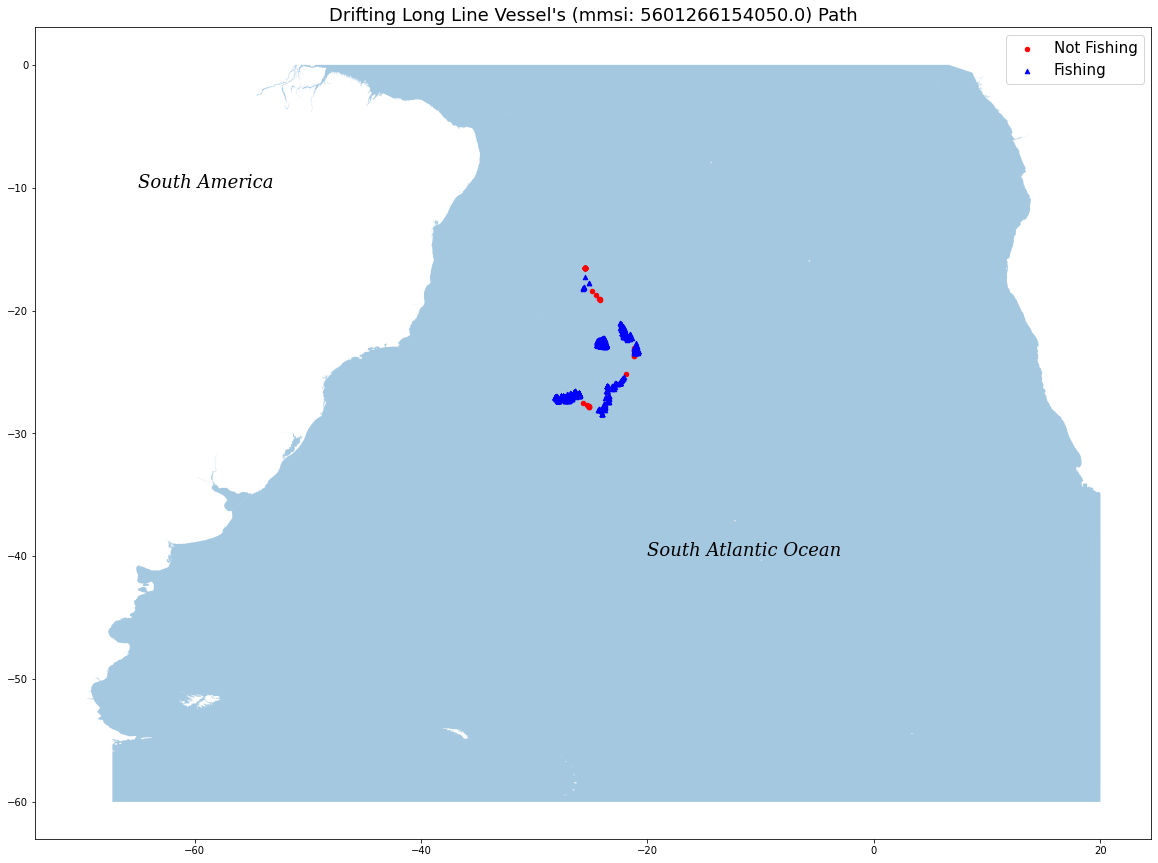

In [424]:
# create the plot  
fig, ax = plt.subplots(figsize = (20, 20)) 
south_atlantic.plot(ax = ax, alpha = 0.4)
plt.title(f'Drifting Long Line Vessel\'s (mmsi: {list(driftingLongLinesMMSIGroups.groups.keys())[0]}) Path', fontdict = {'fontsize': 18})
dLLGeoDF[dLLGeoDF['is_fishing'] <= 0.5].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Not Fishing')
dLLGeoDF[dLLGeoDF['is_fishing'] > 0.5].plot(ax = ax, markersize = 20, color = 'blue', marker = '^', label = 'Fishing')
ax.text(-20, -40, 'South Atlantic Ocean', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(-65, -10, 'South America', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
plt.legend(prop = {'size': 15})

## Fixed Gear  
Fixed gear generally means trapping or potting, and gillnetting, where the catching implement is set, soaked and later retrieved. (Source: [FAO Gillnets](https://www.fao.org/fishery/en/geartype/247/en))

In [425]:
# read in data from the fixed gear vessels file 
fixedGearDF = pd.read_csv(fixed_gear_file)

# peak at data 
fixedGearDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.572519e+12,1.347664e+09,0.0,36054.625000,0.0,0.000000,42.798748,-8.944992,-1.0,gfw
1,7.572519e+12,1.348056e+09,0.0,36054.625000,0.0,0.000000,42.798717,-8.945075,-1.0,gfw
2,7.572519e+12,1.350409e+09,0.0,90970.296875,0.0,198.199997,43.106419,-9.215466,-1.0,gfw
3,7.572519e+12,1.350410e+09,0.0,90970.296875,0.0,186.899994,43.106434,-9.215431,-1.0,gfw
4,7.572519e+12,1.350411e+09,0.0,90970.296875,0.0,190.500000,43.106430,-9.215442,-1.0,gfw


In [426]:
# check data characteristics, same 511 values for course (explained above after code block 28)
fixedGearDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06
mean,1.530752e+14,1.421486e+09,3.761878e+04,5.989848e+04,2.227195e+00,1.877938e+02,5.095086e+01,1.274018e+00,-9.659100e-01
std,8.976383e+13,3.782830e+07,1.090188e+05,1.269729e+05,3.412790e+00,1.177506e+02,5.894565e+00,8.512244e+00,2.173124e-01
min,7.572519e+12,1.325625e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.326460e+01,-1.792441e+02,-1.000000e+00
25%,8.878018e+13,1.387594e+09,0.000000e+00,5.656715e+03,0.000000e+00,7.740000e+01,4.745566e+01,-3.909275e+00,-1.000000e+00
50%,1.305289e+14,1.427254e+09,0.000000e+00,2.690659e+04,1.000000e-01,2.055000e+02,5.050242e+01,-2.333808e+00,-1.000000e+00
75%,2.616830e+14,1.455255e+09,3.413126e+04,5.514391e+04,3.800000e+00,2.870000e+02,5.602126e+01,8.220293e+00,-1.000000e+00
max,2.802913e+14,1.480032e+09,3.099833e+06,1.181676e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.709277e+02,1.000000e+00


In [427]:
# data shape 
fixedGearDF.shape

(1559137, 10)

In [428]:
# drop rows without data for is_fishing
fixedGearDF = fixedGearDF[fixedGearDF['is_fishing'] != -1]
fixedGearDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [429]:
# recheck data shape 
fixedGearDF.shape

(41858, 10)

In [430]:
# check label distribution 
fixedGearDF['is_fishing'].value_counts()

0.000000    29790
1.000000    10665
0.666667      538
0.250000      423
0.333333      405
0.800000       29
0.750000        6
0.400000        2
Name: is_fishing, dtype: int64

In [431]:
# recheck data characteristics after dropping rows missing is_fishing data 
fixedGearDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.185800e+04,4.185800e+04,4.185800e+04,4.185800e+04,41858.000000,41858.000000,41858.000000,41858.000000,41858.000000
mean,1.405469e+14,1.430883e+09,2.314125e+04,4.419514e+04,1.842260,207.619382,51.379668,0.837540,0.269791
std,8.812204e+13,1.115849e+07,9.285800e+04,9.696492e+04,3.140728,119.548799,6.076739,8.988599,0.435842
min,7.572519e+12,1.340576e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.061667,-55.494328,0.000000
25%,5.911250e+13,1.424233e+09,0.000000e+00,5.385033e+03,0.000000,107.699997,49.612662,-7.189246,0.000000
50%,1.061505e+14,1.427413e+09,0.000000e+00,2.624817e+04,0.000000,226.800003,51.133953,-2.960934,0.000000
75%,2.259868e+14,1.439289e+09,1.711682e+04,4.753829e+04,2.700000,308.200012,57.151646,11.366385,1.000000
max,2.802913e+14,1.451623e+09,1.448151e+06,1.472929e+06,102.300003,511.000000,59.587173,47.079002,1.000000


Still records with 511 course value. That will be fixed later.

In [432]:
# check for null values 
fixedGearDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [433]:
# reformat unix timestamps into datetime 
fixedGearFormattedTimestamps = pd.to_datetime(fixedGearDF['timestamp'], unit = 's')
fixedGearDF.insert(2, 'timestamp_reformat', fixedGearFormattedTimestamps)
fixedGearDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,2015-01-02 08:23:08,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,2015-01-02 08:38:07,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [434]:
# add separate month, day of the week, year, and hour columns derived from timstamps
fixedGearDF.insert(3, 'year', fixedGearDF['timestamp_reformat'].dt.year)
# round to closest hour
fixedGearDF.insert(4, 'hour', fixedGearDF['timestamp_reformat'].dt.round('H').dt.hour)
fixedGearDF.insert(5, 'day_of_week', fixedGearDF['timestamp_reformat'].dt.day_name())
fixedGearDF.insert(6, 'month', fixedGearDF['timestamp_reformat'].dt.month_name())

fixedGearDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,2015,8,Friday,January,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,2015,8,Friday,January,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,2015,8,Friday,January,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,2015-01-02 08:23:08,2015,8,Friday,January,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,2015-01-02 08:38:07,2015,9,Friday,January,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [435]:
# count the unique mmsi's 
len(pd.unique(fixedGearDF['mmsi']))

36

In [436]:
# group the fixed gear vessels by their mmsi's 
fixedGearMMSIGroups = fixedGearDF.sort_values(['mmsi', 'timestamp_reformat']).groupby('mmsi')

# peak at first 3 rows in each group
fixedGearMMSIGroups.head(3)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,2015,8,Friday,January,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,2015,8,Friday,January,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,2015,8,Friday,January,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
70274,1.075939e+13,1.420455e+09,2015-01-05 10:43:56,2015,11,Monday,January,9433.749023,12999.680664,0.9,341.899994,55.035072,14.649437,0.0,gfw
70275,1.075939e+13,1.420455e+09,2015-01-05 10:44:45,2015,11,Monday,January,9433.749023,12999.680664,1.4,350.500000,55.035419,14.649340,0.0,gfw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250026,2.733520e+14,1.425188e+09,2015-03-01 05:25:10,2015,5,Sunday,March,0.000000,33733.429688,0.0,308.200012,58.112274,11.366370,0.0,gfw
1250027,2.733520e+14,1.425188e+09,2015-03-01 05:38:49,2015,6,Sunday,March,0.000000,33733.429688,0.0,288.200012,58.112274,11.366388,0.0,gfw
1340439,2.802913e+14,1.340576e+09,2012-06-24 22:05:05,2012,22,Sunday,June,316182.062500,346623.875000,1.4,175.399994,49.793472,-10.941780,1.0,dalhousie_longliner
1340536,2.802913e+14,1.341852e+09,2012-07-09 16:37:17,2012,17,Monday,July,497088.375000,512698.843750,9.2,159.399994,47.806793,-9.623722,0.0,dalhousie_longliner


In [437]:
# plot the ship course of the first fixed gear vessel 
# get the first vessel data 
fixedGearVesselPlotDF = fixedGearMMSIGroups.get_group(list(fixedGearMMSIGroups.groups.keys())[1])

# convert longitude and latitude to Points so we can convert to GeoDataFrame 
dLLPoints1 = [Point(xy) for xy in zip(fixedGearVesselPlotDF['lon'], fixedGearVesselPlotDF['lat'])]

# create the GeoDataFrame
dLLGeoDF1 = gpd.GeoDataFrame(fixedGearVesselPlotDF, crs = crs, geometry = dLLPoints1)
dLLGeoDF1.head()

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,geometry
70274,1.075939e+13,1.420455e+09,2015-01-05 10:43:56,2015,11,Monday,January,9433.749023,12999.680664,0.9,341.899994,55.035072,14.649437,0.0,gfw,POINT (14.64944 55.03507)
70275,1.075939e+13,1.420455e+09,2015-01-05 10:44:45,2015,11,Monday,January,9433.749023,12999.680664,1.4,350.500000,55.035419,14.649340,0.0,gfw,POINT (14.64934 55.03542)
70276,1.075939e+13,1.420455e+09,2015-01-05 10:56:49,2015,11,Monday,January,9999.754883,13416.078125,2.1,310.299988,55.039169,14.646980,0.0,gfw,POINT (14.64698 55.03917)
70277,1.075939e+13,1.420455e+09,2015-01-05 10:56:57,2015,11,Monday,January,9999.754883,13416.078125,2.0,310.299988,55.039169,14.646980,0.0,gfw,POINT (14.64698 55.03917)
70279,1.075939e+13,1.420457e+09,2015-01-05 11:21:48,2015,11,Monday,January,9899.251953,13038.084961,1.2,334.700012,55.046902,14.641488,1.0,gfw,POINT (14.64149 55.04690)


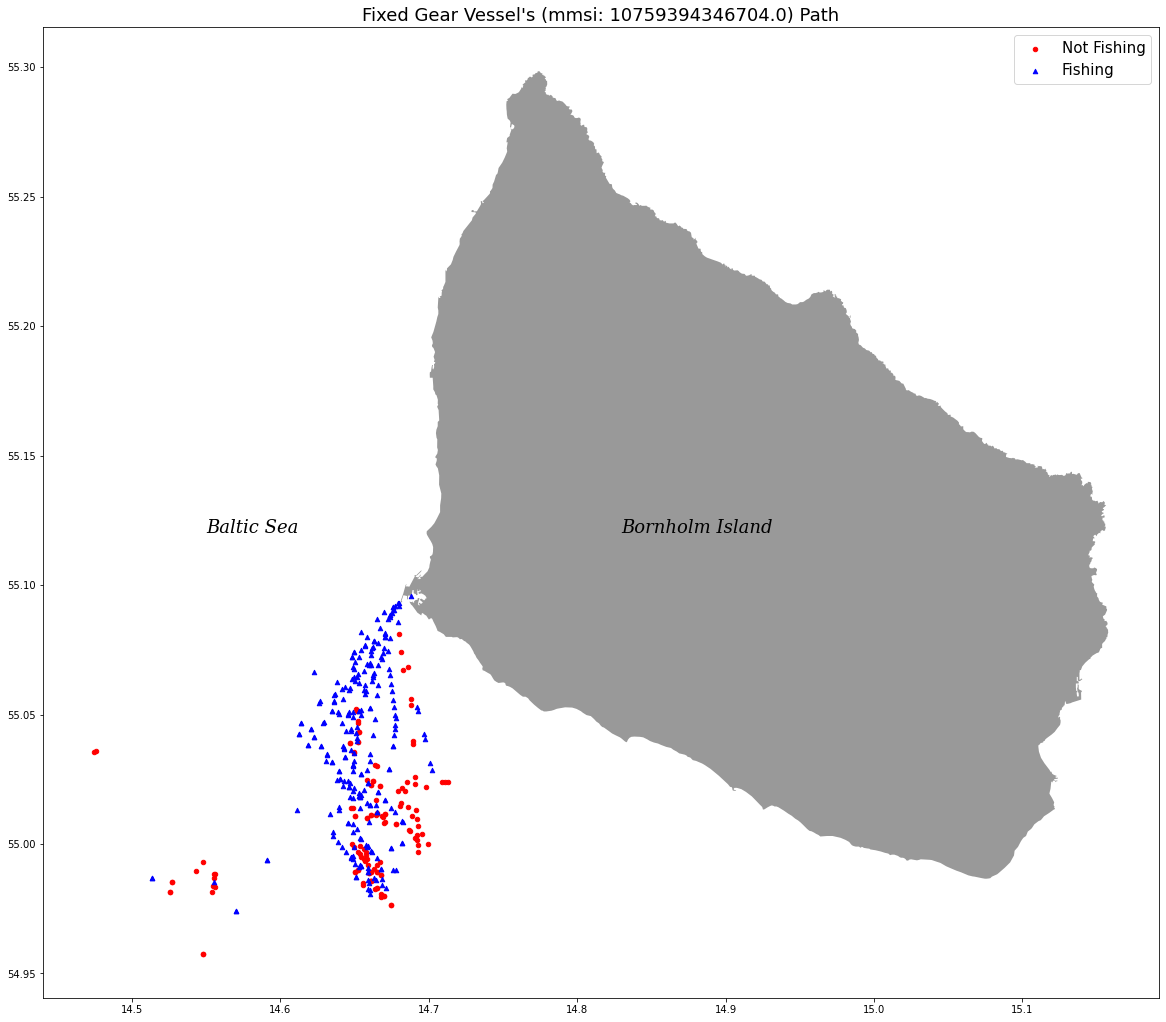

In [438]:
# map the coordinates 
fig, ax = plt.subplots(figsize = (20, 20))
bornholm.plot(ax = ax, alpha = 0.4, cmap = 'gnuplot')
plt.title(f'Fixed Gear Vessel\'s (mmsi: {list(fixedGearMMSIGroups.groups.keys())[1]}) Path', fontdict = {'fontsize': 18})
dLLGeoDF1[dLLGeoDF1['is_fishing'] <= 0.5].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Not Fishing')
dLLGeoDF1[dLLGeoDF1['is_fishing'] > 0.5].plot(ax = ax, markersize = 20, color = 'blue', marker = '^', label = 'Fishing')
ax.text(14.83, 55.12, 'Bornholm Island', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(14.55, 55.12, 'Baltic Sea', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
plt.legend(prop = {'size': 15})

## Pole and Lines  
A pole and line consists of a hooked line attached to a pole. This method is common to sport fisheries (angling) but it is also used in commercial fisheries. Fishing rods/poles are made of wood (including bamboo, also constructed of split cane) and increasingly of fiberglass. (Source: [FAO Pole and Lines](https://www.fao.org/fishery/en/geartype/314/en))

In [439]:
# read in data from the pole and lines vessel file 
poleAndLinesDF = pd.read_csv(pole_and_line_file)

# peak at the data 
poleAndLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.848346e+13,1.340882e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537797,-1.0,gfw
1,1.848346e+13,1.340884e+09,0.000000,2236.013184,0.0,125.199997,28.967373,-13.537838,-1.0,gfw
2,1.848346e+13,1.340885e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
3,1.848346e+13,1.340888e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
4,1.848346e+13,1.340925e+09,1999.950928,2828.357666,8.7,203.100006,28.929653,-13.543955,-1.0,gfw


In [440]:
# check data characteristics
poleAndLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.613150e+05,1.613150e+05,1.613150e+05,1.613150e+05,161315.000000,161315.000000,161315.000000,161315.000000,161315.000000
mean,7.659841e+13,1.414174e+09,4.894434e+04,7.383040e+04,2.111584,132.245911,33.456753,-4.570087,-0.967918
std,5.740577e+13,4.300647e+07,2.036499e+05,2.333604e+05,3.696588,117.424918,5.665633,53.524248,0.205442
min,1.848346e+13,1.327882e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-41.853848,-70.921013,-1.000000
25%,1.848346e+13,1.368384e+09,0.000000e+00,2.236013e+03,0.000000,3.300000,28.965940,-28.527719,-1.000000
50%,8.703142e+13,1.423536e+09,0.000000e+00,1.442185e+04,0.000000,115.199997,33.029419,-16.734444,-1.000000
75%,8.703142e+13,1.456109e+09,2.280295e+04,5.324341e+04,1.800000,228.699997,38.531128,-13.539565,-1.000000
max,2.145727e+14,1.480031e+09,2.110362e+06,3.005100e+06,102.300003,360.000000,77.078987,177.632980,1.000000


In [441]:
# data shape 
poleAndLinesDF.shape

(161315, 10)

In [442]:
# drop rows without data for is_fishing 
poleAndLinesDF = poleAndLinesDF[poleAndLinesDF['is_fishing'] != -1]
poleAndLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [443]:
# recheck data shape 
poleAndLinesDF.shape

(4250, 10)

In [444]:
# check label distribution 
poleAndLinesDF['is_fishing'].value_counts()

0.000000    3176
1.000000     833
0.333333     189
0.750000      31
0.166667      12
0.400000       7
0.666667       2
Name: is_fishing, dtype: int64

In [445]:
# recheck data characteristics after dropping rows missing is_fishing data 
poleAndLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.250000e+03,4.250000e+03,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,1.008980e+14,1.430980e+09,11255.285564,37041.798378,2.695435,144.190588,32.364339,12.034225,0.217737
std,7.472249e+13,5.193688e+06,25190.860093,39794.481810,4.008493,112.251189,2.683747,62.204408,0.397772
min,1.848346e+13,1.422856e+09,0.000000,0.000000,0.000000,0.000000,11.827162,-70.919838,0.000000
25%,1.848346e+13,1.428384e+09,0.000000,2236.013184,0.000000,36.025000,28.968987,-16.734569,0.000000
50%,8.703142e+13,1.429821e+09,0.000000,25238.240234,0.300000,141.349998,32.735371,-16.359985,0.000000
75%,1.961844e+14,1.431658e+09,18027.312500,60206.496094,6.675000,238.199997,33.100632,-13.539548,0.166667
max,2.145727e+14,1.451619e+09,837414.187500,858397.250000,15.200000,359.700012,41.633438,154.059021,1.000000


In [446]:
# check for null values 
poleAndLinesDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [447]:
# reformat unix timestamps into datetime 
poleAndLinesFormattedTimestamps = pd.to_datetime(poleAndLinesDF['timestamp'], unit = 's')
poleAndLinesDF.insert(2, 'timestamp_reformat', poleAndLinesFormattedTimestamps)
poleAndLinesDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,2015-04-01 05:50:33,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,2015-04-01 06:02:52,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [448]:
# add separate month, day of the week, year, and hour columns derived from timstamps
poleAndLinesDF.insert(3, 'year', poleAndLinesDF['timestamp_reformat'].dt.year)
# round to the closest hour 
poleAndLinesDF.insert(4, 'hour', poleAndLinesDF['timestamp_reformat'].dt.round('H').dt.hour)
poleAndLinesDF.insert(5, 'day_of_week', poleAndLinesDF['timestamp_reformat'].dt.day_name())
poleAndLinesDF.insert(6, 'month', poleAndLinesDF['timestamp_reformat'].dt.month_name())

poleAndLinesDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,2015,5,Wednesday,April,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,2015,5,Wednesday,April,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,2015-04-01 05:50:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,2015-04-01 06:02:52,2015,6,Wednesday,April,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [449]:
# count the unique mmsi's 
len(pd.unique(poleAndLinesDF['mmsi']))

6

In [450]:
# group the pole and line vessels by their mmsi's 
poleAndLinesMMSIGroups = poleAndLinesDF.sort_values(['mmsi', 'timestamp_reformat']).groupby('mmsi')

# peak at first 3 rows in each resulting group
poleAndLinesMMSIGroups.head(3)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,2015,5,Wednesday,April,0.000000,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,2015,5,Wednesday,April,0.000000,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,2015,6,Wednesday,April,0.000000,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
59619,4.733417e+13,1.432145e+09,2015-05-20 18:04:05,2015,18,Wednesday,May,13892.102539,24041.039062,8.8,91.300003,41.445370,-70.163803,0.0,gfw
59620,4.733417e+13,1.432146e+09,2015-05-20 18:20:34,2015,18,Wednesday,May,9899.251953,23086.224609,8.0,96.900002,41.442101,-70.114143,0.0,gfw
59621,4.733417e+13,1.432147e+09,2015-05-20 18:36:05,2015,19,Wednesday,May,6324.400391,22203.058594,8.1,97.199997,41.439415,-70.067596,0.0,gfw
94959,8.703142e+13,1.427924e+09,2015-04-01 21:29:18,2015,21,Wednesday,April,0.000000,3162.200195,0.2,330.799988,32.641022,-16.896338,0.0,gfw
94962,8.703142e+13,1.427926e+09,2015-04-01 22:06:21,2015,22,Wednesday,April,0.000000,3162.200195,3.6,11.100000,32.641151,-16.895382,0.0,gfw
94963,8.703142e+13,1.427927e+09,2015-04-01 22:18:40,2015,22,Wednesday,April,0.000000,3162.200195,0.3,5.700000,32.641453,-16.895931,0.0,gfw
130068,1.020291e+14,1.429245e+09,2015-04-17 04:34:25,2015,5,Friday,April,999.975464,28318.910156,0.0,0.000000,34.867249,138.328293,0.0,gfw


In [451]:
# plot the ship course of one of the pole and line vessels
# get the vessel data
poleAndLinesVesselPlotDF = poleAndLinesMMSIGroups.get_group(list(poleAndLinesMMSIGroups.groups.keys())[0])

# convert to long and lat to Points so we can convert to GeoDataFrame 
dLLPoints2 = [Point(xy) for xy in zip(poleAndLinesVesselPlotDF['lon'], poleAndLinesVesselPlotDF['lat'])]

# create GeoDataFrame 
dLLGeoDF2 = gpd.GeoDataFrame(poleAndLinesVesselPlotDF, crs = crs, geometry = dLLPoints2)
dLLGeoDF2.head()

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,geometry
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,2015,5,Wednesday,April,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw,POINT (-13.53957 28.96549)
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,2015,5,Wednesday,April,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw,POINT (-13.53957 28.96548)
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw,POINT (-13.53956 28.96549)
46906,1.848346e+13,1.427867e+09,2015-04-01 05:50:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw,POINT (-13.53956 28.96547)
46907,1.848346e+13,1.427868e+09,2015-04-01 06:02:52,2015,6,Wednesday,April,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw,POINT (-13.53956 28.96547)


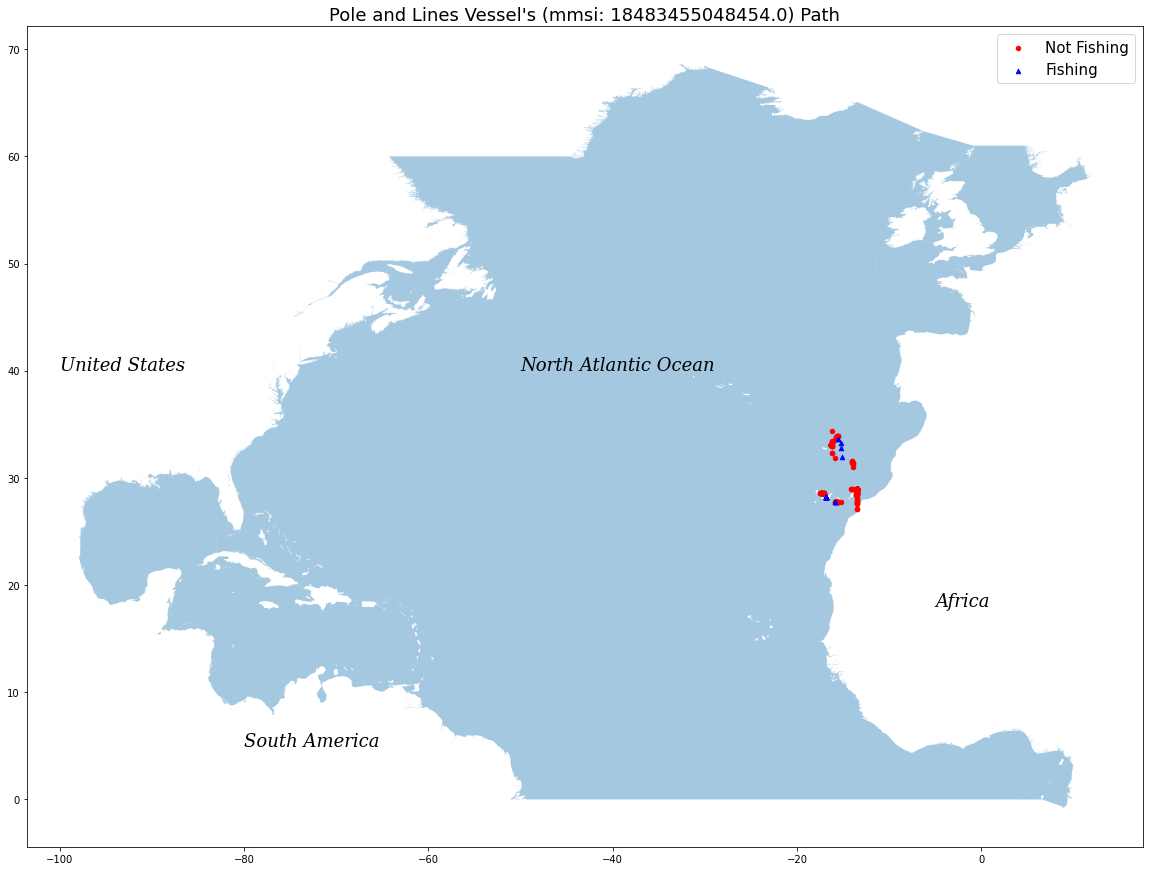

In [452]:
# create the plot '
fig, ax = plt.subplots(figsize = (20, 20))
arrecife.plot(ax = ax, alpha = 0.4)
plt.title(f'Pole and Lines Vessel\'s (mmsi: {list(poleAndLinesMMSIGroups.groups.keys())[0]}) Path', fontdict = {'fontsize': 18})
dLLGeoDF2[dLLGeoDF2['is_fishing'] <= 0.5].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Not Fishing')
dLLGeoDF2[dLLGeoDF2['is_fishing'] > 0.5].plot(ax = ax, markersize = 20, color = 'blue', marker = '^', label = 'Fishing')
ax.text(-50, 40, 'North Atlantic Ocean', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(-100, 40, 'United States', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(-5, 18, 'Africa', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(-80, 5, 'South America', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
plt.legend(prop = {'size': 15})

## Purse Seines  
A purse seine is made of a long wall of netting framed with floatline and leadline (usually, of equal or longer length than the former) and having purse rings hanging from the lower edge of the gear, through which runs a purse line made from steel wire or rope which allow the pursing of the net. For most of the situation, it is the most efficient gear for catching large and small pelagic species that is shoaling. (Source: [FAO Purse\Seines](https://www.fao.org/fishery/en/geartype/249/en))


In [453]:
# read in data from the purse seines vessels file 
purseSeinesDF = pd.read_csv(purse_seines_file)

# peak at the data 
purseSeinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,9.924005e+12,1.379601e+09,0.0,1414.178833,0.0,298.500000,8.861500,-79.668427,-1.0,false_positives
1,9.924005e+12,1.379602e+09,0.0,1414.178833,0.0,298.500000,8.861506,-79.668442,-1.0,false_positives
2,9.924005e+12,1.379604e+09,0.0,1414.178833,0.1,128.399994,8.861511,-79.668488,-1.0,false_positives
3,9.924005e+12,1.379605e+09,0.0,1414.178833,0.1,111.199997,8.861511,-79.668480,-1.0,false_positives
4,9.924005e+12,1.379608e+09,0.0,1414.178833,0.0,41.700001,8.861502,-79.668503,-1.0,false_positives


In [454]:
# check data characteristics 
purseSeinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.545323e+06,1.545323e+06,1.545323e+06,1.545323e+06,1.545316e+06,1.545316e+06,1.545323e+06,1.545323e+06,1.545323e+06
mean,8.788081e+13,1.431543e+09,2.301199e+05,3.420745e+05,5.119294e+00,1.905941e+02,1.390564e+01,1.472753e+01,-9.833250e-01
std,6.522389e+13,3.645865e+07,3.841463e+05,5.070968e+05,5.593512e+00,1.042562e+02,1.891573e+01,1.116258e+02,1.418592e-01
min,9.924005e+12,1.325378e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.922275e+01,-1.800000e+02,-1.000000e+00
25%,3.832297e+13,1.409017e+09,0.000000e+00,8.062060e+03,1.000000e-01,9.820000e+01,-4.091158e-01,-7.966909e+01,-1.000000e+00
50%,5.966517e+13,1.438458e+09,4.049592e+04,9.693059e+04,1.300000e+00,2.034000e+02,5.338995e+00,-1.897600e+00,-1.000000e+00
75%,1.583170e+14,1.462147e+09,2.866600e+05,4.934421e+05,1.120000e+01,2.791000e+02,3.510037e+01,1.410436e+02,-1.000000e+00
max,2.679667e+14,1.480032e+09,2.315626e+06,6.728604e+06,1.023000e+02,5.110000e+02,7.833025e+01,1.799934e+02,1.000000e+00


In [455]:
# data shape
purseSeinesDF.shape

(1545323, 10)

In [456]:
# drop rows without data for is_fishing 
purseSeinesDF = purseSeinesDF[purseSeinesDF['is_fishing'] != -1]
purseSeinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [457]:
# recheck data shape 
purseSeinesDF.shape

(22849, 10)

In [458]:
# check label distribution 
purseSeinesDF['is_fishing'].value_counts()

0.000000    19737
1.000000     2740
0.666667      155
0.333333      117
0.250000       76
0.750000       24
Name: is_fishing, dtype: int64

In [459]:
# recheck data characteristics after dropping rows missing is_fishing data 
purseSeinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,2.284900e+04,2.284900e+04,2.284900e+04,2.284900e+04,22849.000000,22849.000000,22849.000000,22849.000000,22849.000000
mean,1.137223e+14,1.402467e+09,1.823926e+05,2.690304e+05,4.176454,185.983172,20.604975,-11.435169,0.127766
std,5.790158e+13,3.170493e+07,3.250248e+05,4.248823e+05,5.276772,107.020455,20.312320,96.550441,0.328604
min,9.924005e+12,1.327091e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-10.776958,-177.983887,0.000000
25%,6.371639e+13,1.372868e+09,0.000000e+00,4.123004e+03,0.000000,91.500000,1.999383,-79.668411,0.000000
50%,1.332927e+14,1.422078e+09,4.123004e+03,3.471226e+04,0.600000,202.600006,8.861485,10.303658,0.000000
75%,1.710880e+14,1.426226e+09,2.261028e+05,3.976358e+05,9.900000,278.799988,42.356709,16.627573,0.000000
max,2.679667e+14,1.451378e+09,1.985473e+06,2.623922e+06,16.400000,511.000000,59.174519,179.941940,1.000000


In [460]:
# check for null values 
purseSeinesDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [461]:
# reformat unix timestamps into datetime 
purseSeinesFormattedTimestamps = pd.to_datetime(purseSeinesDF['timestamp'], unit = 's')
purseSeinesDF.insert(2, 'timestamp_reformat', purseSeinesFormattedTimestamps)
purseSeinesDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,2015-04-01 15:03:23,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,2015-07-12 13:27:56,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,2015-07-12 13:47:57,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,2015-07-12 13:54:57,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,2015-07-12 13:58:34,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [462]:
# add separate month, day of the week, year, and hour columns derived from timsestamps 
purseSeinesDF.insert(3, 'year', purseSeinesDF['timestamp_reformat'].dt.year)
# round to closest hour 
purseSeinesDF.insert(4, 'hour', purseSeinesDF['timestamp_reformat'].dt.round('H').dt.hour)
purseSeinesDF.insert(5, 'day_of_week', purseSeinesDF['timestamp_reformat'].dt.day_name())
purseSeinesDF.insert(6, 'month', purseSeinesDF['timestamp_reformat'].dt.month_name())

purseSeinesDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,2015-04-01 15:03:23,2015,15,Wednesday,April,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,2015-07-12 13:27:56,2015,13,Sunday,July,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,2015-07-12 13:47:57,2015,14,Sunday,July,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,2015-07-12 13:54:57,2015,14,Sunday,July,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,2015-07-12 13:58:34,2015,14,Sunday,July,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [463]:
# count the unique mmsi's 
len(pd.unique(purseSeinesDF['mmsi']))

26

In [464]:
# group the purse seines vessels by their mmsi's 
purseSeinesMMSIGroups = purseSeinesDF.sort_values(['mmsi', 'timestamp_reformat']).groupby('mmsi')

# peak at first 3 rows in each resulting group 
purseSeinesMMSIGroups.head(3)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,2015-04-01 15:03:23,2015,15,Wednesday,April,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.00,false_positives
247567,1.088051e+13,1.338911e+09,2012-06-05 15:42:32,2012,16,Tuesday,June,305757.125000,305757.125000,13.8,165.300003,14.187220,141.983734,0.00,dalhousie_ps
247606,1.088051e+13,1.339029e+09,2012-06-07 00:26:45,2012,0,Thursday,June,114766.515625,596546.312500,13.5,130.100006,8.323613,143.443741,0.00,dalhousie_ps
247607,1.088051e+13,1.339030e+09,2012-06-07 00:39:07,2012,1,Thursday,June,110491.632812,598612.062500,13.7,128.500000,8.294512,143.479843,0.00,dalhousie_ps
879322,1.117001e+13,1.420534e+09,2015-01-06 08:45:34,2015,9,Tuesday,January,5830.808594,48330.996094,7.5,99.199997,42.730705,-9.154881,0.00,gfw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795093,1.928034e+14,1.339397e+09,2012-06-11 06:47:27,2012,7,Monday,June,43323.296875,530309.562500,0.4,170.800003,8.863287,145.506561,0.00,dalhousie_ps
795103,1.928034e+14,1.339504e+09,2012-06-12 12:30:28,2012,13,Tuesday,June,96044.507812,548137.062500,0.2,256.799988,6.496233,146.996857,0.00,dalhousie_ps
1271166,2.679667e+14,1.425238e+09,2015-03-01 19:27:11,2015,19,Sunday,March,3605.462891,47126.332031,1.4,173.399994,38.063293,24.179964,0.25,gfw
1271167,2.679667e+14,1.425239e+09,2015-03-01 19:39:32,2015,20,Sunday,March,4242.536621,48082.078125,4.6,203.300003,38.059635,24.179068,0.25,gfw


In [465]:
# plot the ship course of the second purse seines vessel 
# get the first vessel data 
purseSeinesVesselPlotDF = purseSeinesMMSIGroups.get_group(list(purseSeinesMMSIGroups.groups.keys())[1])

# convert long and lat to Points so we can convert dataframe to GeoDataFrame  
dLLPoints3 = [Point(xy) for xy in zip(purseSeinesVesselPlotDF['lon'], purseSeinesVesselPlotDF['lat'])]

# create GeoDataFrame
dLLGeoDF3 = gpd.GeoDataFrame(purseSeinesVesselPlotDF, crs = crs, geometry = dLLPoints3)
dLLGeoDF3.head()

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,geometry
247567,1.088051e+13,1.338911e+09,2012-06-05 15:42:32,2012,16,Tuesday,June,305757.125000,305757.1250,13.8,165.300003,14.187220,141.983734,0.0,dalhousie_ps,POINT (141.98373 14.18722)
247606,1.088051e+13,1.339029e+09,2012-06-07 00:26:45,2012,0,Thursday,June,114766.515625,596546.3125,13.5,130.100006,8.323613,143.443741,0.0,dalhousie_ps,POINT (143.44374 8.32361)
247607,1.088051e+13,1.339030e+09,2012-06-07 00:39:07,2012,1,Thursday,June,110491.632812,598612.0625,13.7,128.500000,8.294512,143.479843,0.0,dalhousie_ps,POINT (143.47984 8.29451)
247618,1.088051e+13,1.339077e+09,2012-06-07 13:53:20,2012,14,Thursday,June,152943.953125,737860.6250,14.4,187.199997,5.319983,143.234283,0.0,dalhousie_ps,POINT (143.23428 5.31998)
247632,1.088051e+13,1.339135e+09,2012-06-08 05:58:42,2012,6,Friday,June,209398.781250,688303.5625,4.3,343.100006,4.813727,142.957047,0.0,dalhousie_ps,POINT (142.95705 4.81373)


Text(137, 30, 'Phillippine Sea')

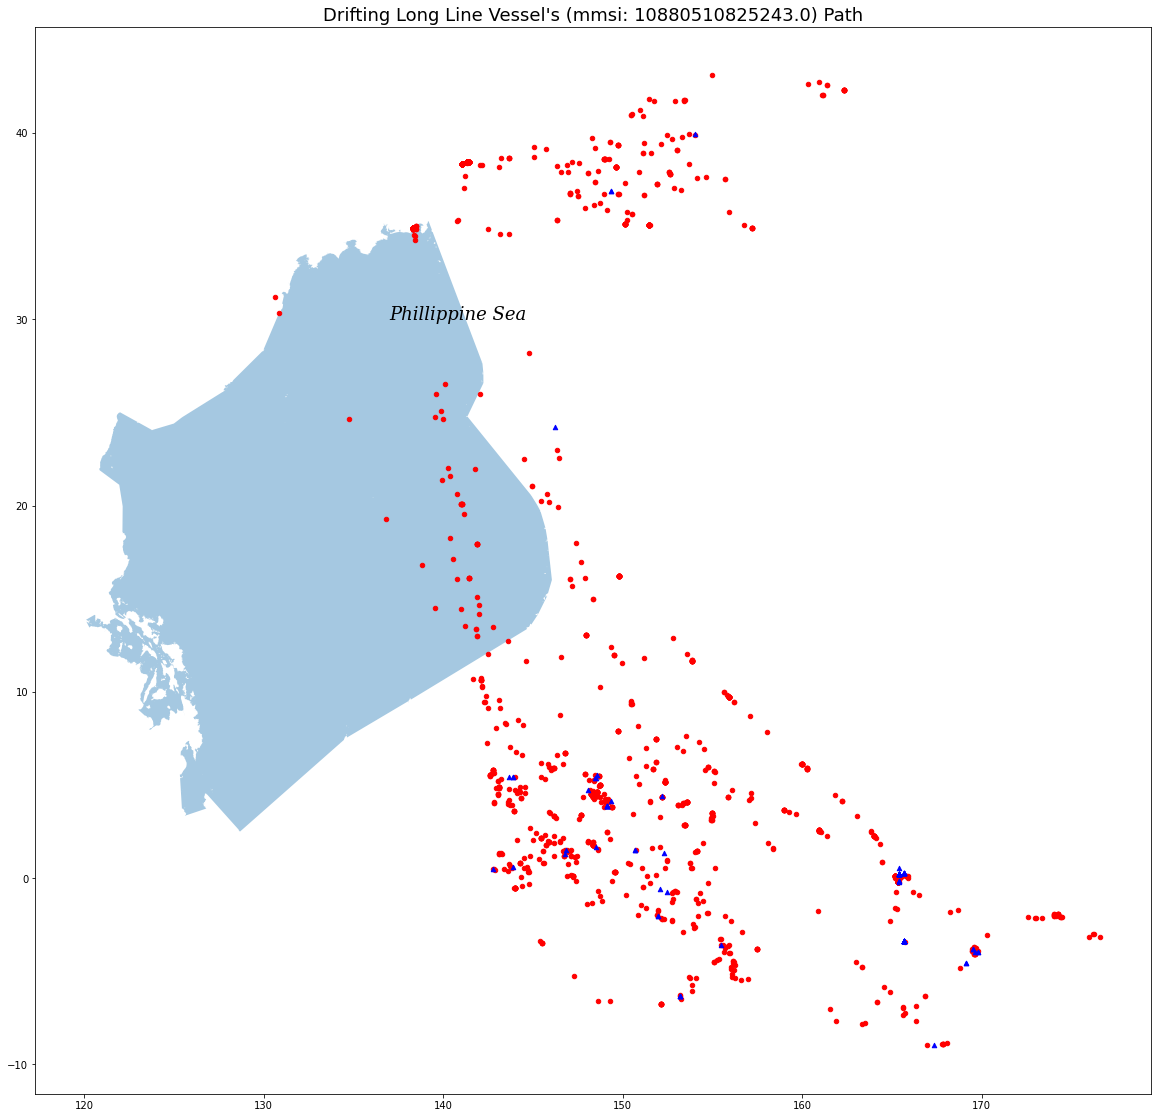

In [466]:
# create the plot 
fig, ax = plt.subplots(figsize = (20, 20))
phillippine_sea.plot(ax = ax, alpha = 0.4)
plt.title(f'Drifting Long Line Vessel\'s (mmsi: {list(purseSeinesMMSIGroups.groups.keys())[1]}) Path', fontdict = {'fontsize': 18})
dLLGeoDF3[dLLGeoDF3['is_fishing'] <= 0.5].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Not Fishing')
dLLGeoDF3[dLLGeoDF3['is_fishing'] > 0.5].plot(ax = ax, markersize = 20, color = 'blue', marker = '^', label = 'Fishing')
ax.text(137, 30, 'Phillippine Sea', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})


## Trawlers  
The trawls are cone-shaped net (made from two, four or more panels) which are towed, by one or two boats, on the bottom or in midwater (pelagic). The cone-shaped body ends in a bag or coded. The horizontal opening of the gear while it is towed is maintained by beams, otter boards or by the distance between the two towing vessels (pair trawling). Floats and weights and/or hydrodynamic devices provide for the vertical opening. Two parallel trawls might be rigged between two otter boards (twin trawls). The mesh size in the codend or special designed devices is used to regulate the size and species to be captured. (Source: [FAO Trawls](https://www.fao.org/fishery/en/geartype/103/en))



In [467]:
# read in data from the trawler vessels file 
trawlersDF = pd.read_csv(trawlers_file)

# peak at the data 
trawlersDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw


In [468]:
# check data charactertics 
trawlersDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.369101e+06,4.369101e+06,4.369101e+06,4.369101e+06,4.369023e+06,4.369023e+06,4.369101e+06,4.369101e+06,4.369101e+06
mean,1.578952e+14,1.426220e+09,7.819802e+04,1.496648e+05,2.972401e+00,1.744043e+02,3.266757e+01,4.927771e+00,-9.449078e-01
std,9.494779e+13,3.876472e+07,2.040747e+05,3.279532e+05,4.105081e+00,1.154701e+02,3.837240e+01,8.127552e+01,2.844518e-01
min,1.252340e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.498024e+01,-1.799996e+02,-1.000000e+00
25%,7.726193e+13,1.397205e+09,0.000000e+00,2.236013e+03,0.000000e+00,6.480000e+01,3.623107e+01,-8.288531e+00,-1.000000e+00
50%,1.753874e+14,1.434811e+09,4.242537e+03,3.605462e+04,1.500000e+00,1.870000e+02,5.209994e+01,4.584417e+00,-1.000000e+00
75%,2.402260e+14,1.458922e+09,5.578393e+04,9.608094e+04,4.500000e+00,2.760000e+02,5.463578e+01,1.432063e+01,-1.000000e+00
max,2.775153e+14,1.480032e+09,3.257453e+06,1.245220e+07,1.023000e+02,5.110000e+02,8.461642e+01,1.799934e+02,1.000000e+00


In [469]:
# data shape 
trawlersDF.shape

(4369101, 10)

In [470]:
# drop rows without data for is_fishing 
trawlersDF = trawlersDF[trawlersDF['is_fishing'] != -1]
trawlersDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [471]:
# recheck data shape 
trawlersDF.shape

(177394, 10)

In [472]:
# check label distribution 
trawlersDF['is_fishing'].value_counts()

0.000000    112999
1.000000     61930
0.666667      1639
0.333333       760
0.750000        34
0.250000        32
Name: is_fishing, dtype: int64

In [473]:
# recheck data characteristics after dropping rows missing is_fishing data 
trawlersDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.773940e+05,1.773940e+05,1.773940e+05,1.773940e+05,177392.000000,177392.000000,177394.000000,177394.000000,177394.000000
mean,1.922262e+14,1.421315e+09,1.867010e+05,2.744289e+05,2.949755,182.669731,44.739526,-2.580715,0.356886
std,8.672616e+13,2.682760e+07,3.758584e+05,4.773176e+05,3.837859,114.434297,32.839900,42.384756,0.475862
min,1.252340e+12,1.325410e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-50.192177,-179.691055,0.000000
25%,1.214265e+14,1.418116e+09,0.000000e+00,2.236013e+03,0.000000,76.800003,43.337376,-8.691646,0.000000
50%,2.226561e+14,1.425065e+09,3.999902e+03,5.532495e+04,1.400000,196.899994,54.630447,5.414743,0.000000
75%,2.690503e+14,1.440573e+09,1.373575e+05,2.460021e+05,4.200000,280.899994,64.123289,16.547461,1.000000
max,2.775153e+14,1.460698e+09,2.853625e+06,3.836963e+06,102.300003,360.000000,78.925163,179.699615,1.000000


In [474]:
# check for null values 
trawlersDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  2
course                 2
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [475]:
# check the rows with missing speed and course values 
trawlersDF[trawlersDF['speed'].isnull() | trawlersDF['course'].isnull()]

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
3303255,2.748501e+14,1.430833e+09,1233371.625,1400349.125,NaN,NaN,-43.842186,-86.200233,1.0,dalhousie_trawl
3303417,2.748501e+14,1.430893e+09,1239125.750,1376676.000,NaN,NaN,-43.146439,-86.096268,0.0,dalhousie_trawl


In [476]:
# since it is only two rows, we'll just drop them 
trawlersDF = trawlersDF[~trawlersDF['speed'].isnull()]

# recheck that there are no more null values 
trawlersDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [477]:
# reformat unix timestamps into datetimes 
trawlersFormattedTimestamps = pd.to_datetime(trawlersDF['timestamp'], unit = 's')
trawlersDF.insert(2, 'timestamp_reformat', trawlersFormattedTimestamps)
trawlersDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [478]:
# add separate month, day of the week, year, and hour columns derived from timstamps
trawlersDF.insert(3, 'year', trawlersDF['timestamp_reformat'].dt.year)
# round to closest hour 
trawlersDF.insert(4, 'hour', trawlersDF['timestamp_reformat'].dt.round('H').dt.hour)
trawlersDF.insert(5, 'day_of_week', trawlersDF['timestamp_reformat'].dt.day_name())
trawlersDF.insert(6, 'month', trawlersDF['timestamp_reformat'].dt.month_name())

trawlersDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,2015-01-01 05:08:23,2015,5,Thursday,January,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,2015-01-01 05:20:34,2015,5,Thursday,January,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,2015-01-01 05:32:53,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,2015-01-01 05:45:23,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,2015-01-01 05:57:24,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [479]:
# count the unique mmsi's 
len(pd.unique(trawlersDF['mmsi']))

45

## Trollers  
A trolling line consists of a line with natural or artificial baited hooks and is trailed by a vessel near the surface or at a certain depth. Several lines are often towed at the same time, by using outriggers to keep the lines away from the wake of the vessel. The line are hauled by hand or with small winches. A piece of rubber is often included in each line as a shock absorber. (Source: [FAO Trolling Lines](https://www.fao.org/fishery/en/geartype/235/en))


In [480]:
# read in the data from the troller vessels file
trollersDF = pd.read_csv(trollers_file)

# peak at the data 
trollersDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.652701e+13,1.337836e+09,0.0,3162.200195,0.0,0.000000,51.887592,4.356583,-1.0,gfw
1,7.652701e+13,1.338199e+09,0.0,4999.877441,0.0,0.000000,51.242130,4.403008,-1.0,gfw
2,7.652701e+13,1.343752e+09,0.0,66308.250000,8.6,292.200012,51.960873,5.196125,-1.0,gfw
3,7.652701e+13,1.350795e+09,0.0,15296.682617,0.0,0.000000,51.231094,4.526647,-1.0,gfw
4,7.652701e+13,1.351808e+09,0.0,15296.682617,0.0,0.000000,51.231098,4.526487,-1.0,gfw


In [481]:
# check the data characteristics 
trollersDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.662430e+05,1.662430e+05,166243.000000,1.662430e+05,166243.000000,166243.000000,166243.000000,166243.000000,166243.000000
mean,1.486917e+14,1.426558e+09,5116.678753,1.508669e+04,1.343616,147.816762,51.137754,1.448651,-0.934469
std,6.043265e+13,4.044695e+07,13921.012902,2.049972e+04,2.719976,124.286331,7.369866,45.366115,0.312635
min,7.652701e+13,1.325625e+09,0.000000,0.000000e+00,0.000000,0.000000,19.234579,-125.083504,-1.000000
25%,1.129409e+14,1.405839e+09,0.000000,1.414179e+03,0.000000,0.000000,41.640491,12.241529,-1.000000
50%,1.129409e+14,1.436347e+09,999.975464,6.708039e+03,0.000000,174.399994,55.475067,12.274098,-1.000000
75%,1.670724e+14,1.461682e+09,999.975464,1.749243e+04,0.400000,252.500000,57.109627,15.574390,-1.000000
max,2.740638e+14,1.480032e+09,97742.171875,1.441175e+06,102.300003,360.000000,57.973133,41.346321,1.000000


In [482]:
# data shape 
trollersDF.shape

(166243, 10)

In [483]:
# drop rows without data for is_fishing 
trollersDF = trollersDF[trollersDF['is_fishing'] != -1]
trollersDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [484]:
# recheck data shape 
trollersDF.shape

(7845, 10)

In [485]:
# check label distributions 
trollersDF['is_fishing'].value_counts()

0.000000    4746
1.000000    2966
0.666667     116
0.333333      17
Name: is_fishing, dtype: int64

In [486]:
# recheck data characteristics after dropping rows missing is_fishing data 
trollersDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,7.845000e+03,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,1.505007e+14,1.439534e+09,17620.132380,28822.248660,2.482116,143.537259,48.096910,-24.262162,0.388655
std,6.868728e+13,6.515305e+06,25036.048271,34366.791914,3.167338,120.357403,7.167645,67.694449,0.483596
min,7.652701e+13,1.425187e+09,0.000000,0.000000,0.000000,0.000000,38.192352,-125.083504,0.000000
25%,1.129409e+14,1.435417e+09,0.000000,1414.178833,0.000000,0.000000,41.267948,-124.331360,0.000000
50%,1.259544e+14,1.440579e+09,999.975464,8062.060059,0.700000,160.100006,46.981327,12.241538,0.000000
75%,1.670724e+14,1.444766e+09,38209.007812,64620.394531,5.600000,238.000000,57.109619,15.665465,1.000000
max,2.740638e+14,1.446354e+09,94257.960938,117644.898438,13.200000,359.899994,57.939480,36.655247,1.000000


In [487]:
# check for null values 
trollersDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [488]:
# reformat unix timestamps into datetime 
trollersFormattedTimestamps = pd.to_datetime(trollersDF['timestamp'], unit = 's')
trollersDF.insert(2, 'timestamp_reformat', trollersFormattedTimestamps)
trollersDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,2015-05-07 13:18:41,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,2015-05-07 13:34:03,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,2015-05-07 13:58:40,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,2015-05-07 14:12:11,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,2015-05-07 14:24:16,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [489]:
# add separate month, day of the week, year, and hour columns derived from timstamps
trollersDF.insert(3, 'year', trollersDF['timestamp_reformat'].dt.year)
# round to closest hour 
trollersDF.insert(4, 'hour', trollersDF['timestamp_reformat'].dt.round('H').dt.hour)
trollersDF.insert(5, 'day_of_week', trollersDF['timestamp_reformat'].dt.day_name())
trollersDF.insert(6, 'month', trollersDF['timestamp_reformat'].dt.month_name())

trollersDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,2015-05-07 13:18:41,2015,13,Thursday,May,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,2015-05-07 13:34:03,2015,14,Thursday,May,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,2015-05-07 13:58:40,2015,14,Thursday,May,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,2015-05-07 14:12:11,2015,14,Thursday,May,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,2015-05-07 14:24:16,2015,14,Thursday,May,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [490]:
# count the unique mmsi's 
len(pd.unique(trollersDF['mmsi']))

5

## Unknown  
Vessels with unkown fishing gear types. 

In [491]:
# read in data from the unknown vessels file 
unkownDF = pd.read_csv(unknown_file)

# peak at the data 
unkownDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.1,62.700001,2.230797,157.382812,-1.0,crowd_sourced
1,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.8,65.199997,2.232352,157.386047,-1.0,crowd_sourced
2,1.833071e+14,1.343792e+09,343947.9375,513526.09375,13.0,61.700001,2.410787,157.745605,-1.0,crowd_sourced
3,1.833071e+14,1.343799e+09,369211.7500,491134.56250,13.4,63.799999,2.591992,158.094574,-1.0,crowd_sourced
4,1.833071e+14,1.343805e+09,362496.2500,472878.43750,12.6,66.000000,2.759518,158.458908,-1.0,crowd_sourced


In [492]:
# check data characteristics 
unkownDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,6.811552e+06,6.811552e+06,6.811552e+06,6.811552e+06,6.811533e+06,6.811533e+06,6.811552e+06,6.811552e+06,6.811552e+06
mean,1.341339e+14,1.436159e+09,3.244386e+05,4.786299e+05,3.791863e+00,1.835413e+02,2.010856e+01,1.666546e+01,-9.835547e-01
std,7.713338e+13,3.584728e+07,5.121758e+05,7.014247e+05,5.270977e+00,1.147332e+02,3.895049e+01,8.296402e+01,1.596271e-01
min,1.272260e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.367238e+01,-1.799992e+02,-1.000000e+00
25%,8.079808e+13,1.415268e+09,0.000000e+00,1.771961e+04,0.000000e+00,8.150000e+01,-2.014818e+01,-2.499953e+01,-1.000000e+00
50%,1.314049e+14,1.446398e+09,3.801222e+04,9.761932e+04,2.100000e+00,1.935000e+02,3.569063e+01,6.278300e+00,-1.000000e+00
75%,1.851914e+14,1.464825e+09,5.189448e+05,7.388547e+05,7.200000e+00,2.825000e+02,5.600087e+01,5.750281e+01,-1.000000e+00
max,2.767289e+14,1.480032e+09,3.509276e+06,1.095999e+07,1.023000e+02,5.110000e+02,8.468929e+01,1.799930e+02,1.000000e+00


In [493]:
# data shape 
unkownDF.shape

(6811552, 10)

In [494]:
# drop rows without data for is_fishing 
unkownDF = unkownDF[unkownDF['is_fishing'] != -1]
unkownDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [495]:
# recheck data shape 
unkownDF.shape

(79918, 10)

In [496]:
# check label distribution 
unkownDF['is_fishing'].value_counts()

0.000000    45957
1.000000    30201
0.333333     1799
0.666667     1280
0.750000      547
0.250000      130
0.800000        4
Name: is_fishing, dtype: int64

In [497]:
# recheck data characteristics 
unkownDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,7.991800e+04,7.991800e+04,7.991800e+04,7.991800e+04,79918.000000,79918.000000,79918.000000,79918.000000,79918.000000
mean,1.016341e+14,1.434631e+09,1.519976e+05,2.270033e+05,2.636859,164.556731,35.568734,6.028609,0.401661
std,7.910686e+13,1.873148e+07,4.178913e+05,5.561067e+05,3.353635,115.308308,28.360435,61.348851,0.479765
min,1.272260e+12,1.332999e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-47.129448,-179.981094,0.000000
25%,1.775611e+13,1.424820e+09,0.000000e+00,1.627842e+04,0.000000,58.599998,34.863380,-25.669664,0.000000
50%,9.250191e+13,1.434472e+09,6.324400e+03,5.035748e+04,1.000000,168.600006,39.079050,6.004223,0.000000
75%,1.333511e+14,1.449288e+09,5.303642e+04,9.480801e+04,4.100000,267.874992,53.409527,13.506794,1.000000
max,2.746770e+14,1.472890e+09,2.186114e+06,2.845082e+06,64.199997,511.000000,76.409363,179.933273,1.000000


In [498]:
# check for null values 
unkownDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [499]:
# reformat unix timestamps into datetime 
unknownFormattedTimestamps = pd.to_datetime(unkownDF['timestamp'], unit = 's')
unkownDF.insert(2, 'timestamp_reformat', unknownFormattedTimestamps)
unkownDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,2014-07-21 12:42:59,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,2014-07-21 13:13:02,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,2014-07-21 14:37:02,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,2014-07-21 15:48:59,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,2014-07-21 21:25:01,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [500]:
# add separate month, day of the week, year, and hour columns derived from timstamps
unkownDF.insert(3, 'year', unkownDF['timestamp_reformat'].dt.year)
# round to closest hour 
unkownDF.insert(4, 'hour', unkownDF['timestamp_reformat'].dt.round('H').dt.hour)
unkownDF.insert(5, 'day_of_week', unkownDF['timestamp_reformat'].dt.day_name())
unkownDF.insert(6, 'month', unkownDF['timestamp_reformat'].dt.month_name())

unkownDF.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,2014-07-21 12:42:59,2014,13,Monday,July,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,2014-07-21 13:13:02,2014,13,Monday,July,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,2014-07-21 14:37:02,2014,15,Monday,July,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,2014-07-21 15:48:59,2014,16,Monday,July,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,2014-07-21 21:25:01,2014,21,Monday,July,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [501]:
# count the unique mmsi's 
len(pd.unique(unkownDF['mmsi']))

102

# Exploratory Analysis (Combined Data)  
---

## Combine Data
Combine the different vessel types data into one training set dataframe. 

In [502]:
# first need to add data column for fishing gear type 
driftingLongLinesDF['fishing_type'] = 'drifting_long_line'
fixedGearDF['fishing_type'] = 'fixed_gear'
poleAndLinesDF['fishing_type'] = 'pole_line'
purseSeinesDF['fishing_type'] = 'purse_seines'
trawlersDF['fishing_type'] = 'trawler'
trollersDF['fishing_type'] = 'troller'
unkownDF['fishing_type'] = 'unknown'

# concat the dataframes together 
frames = [driftingLongLinesDF, fixedGearDF, poleAndLinesDF, purseSeinesDF, trawlersDF, trollersDF, unkownDF]
train_df = pd.concat(frames)

In [503]:
# check random sample of 20 rows 
train_df.sample(20)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,fishing_type
379826,3.900562e+13,1.365307e+09,2013-04-07 04:03:07,2013,4,Sunday,April,0.000000e+00,4.123004e+03,0.0,30.400000,5.291178,-4.016227,0.0,dalhousie_ps,purse_seines
1255032,2.733520e+14,1.429468e+09,2015-04-19 18:24:50,2015,18,Sunday,April,0.000000e+00,3.373343e+04,0.0,16.900000,58.112259,11.366402,0.0,gfw,fixed_gear
3150052,2.690503e+14,1.436315e+09,2015-07-08 00:17:03,2015,0,Wednesday,July,2.828358e+03,6.129287e+04,13.8,69.300003,64.049522,-52.204426,0.0,dalhousie_trawl,trawler
4973438,4.097664e+13,1.417519e+09,2014-12-02 11:10:37,2014,11,Tuesday,December,4.303660e+05,5.020415e+05,0.5,27.100000,-16.384939,7.806318,1.0,crowd_sourced,drifting_long_line
1584659,2.248331e+14,1.435030e+09,2015-06-23 03:27:12,2015,3,Tuesday,June,0.000000e+00,9.999755e+02,0.0,0.000000,40.786194,14.362643,0.0,gfw,trawler
768808,1.089163e+14,1.435205e+09,2015-06-25 04:08:04,2015,4,Thursday,June,4.301057e+04,1.612040e+05,1.8,329.600006,36.131550,13.106624,1.0,gfw,trawler
1194347,1.867463e+14,1.450179e+09,2015-12-15 11:30:56,2015,12,Tuesday,December,6.369302e+04,1.161780e+05,9.5,215.000000,42.622379,15.504532,1.0,gfw,trawler
87835,1.252340e+12,1.448610e+09,2015-11-27 07:42:06,2015,8,Friday,November,0.000000e+00,1.999951e+03,0.0,0.000000,52.458050,4.582833,0.0,gfw,trawler
2770733,1.439069e+14,1.417303e+09,2014-11-29 23:10:08,2014,23,Saturday,November,1.414179e+03,5.656715e+03,0.2,162.899994,-9.118637,-78.577789,0.0,dalhousie_trawl,trawler
5217244,9.966043e+13,1.428637e+09,2015-04-10 03:30:45,2015,4,Friday,April,4.472026e+03,7.093485e+04,0.1,293.100006,44.284180,14.615490,1.0,gfw,unknown


In [504]:
# check label distributions 
train_df['is_fishing'].value_counts()

0.000000    295978
1.000000    247497
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: is_fishing, dtype: int64

In [505]:
# set anything with a value of >= 0.5 to 1.0 for fishing 
train_df.loc[train_df['is_fishing'] >= 0.5, 'is_fishing'] = 1.0
# set anything with a value of < 0.5 to 1.0 for fishing 
train_df.loc[train_df['is_fishing'] < 0.5, 'is_fishing'] = 0.0

# recheck label distributions 
train_df['is_fishing'].value_counts()

0.0    300765
1.0    253088
Name: is_fishing, dtype: int64

In [506]:
# deal with categorical data 
# convert day_of_week and month columns to numbers 
train_df.insert(5, 'day_of_week_num', train_df['timestamp_reformat'].dt.day_of_week)
train_df.insert(6, 'month_num', train_df['timestamp_reformat'].dt.month)

# one hot encode fishing_type
train_df = pd.concat([train_df, pd.get_dummies(train_df['fishing_type'])], axis = 1)
train_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week_num,month_num,day_of_week,month,distance_from_shore,...,is_fishing,source,fishing_type,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,5,6,Saturday,June,111123.328125,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,1,6,Tuesday,June,329078.531250,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,2012,7,3,8,Thursday,August,86831.046875,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,2012,5,4,8,Friday,August,98881.343750,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,2012,6,2,9,Wednesday,September,74247.757812,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0


## Visualizations

Text(0.5, 1.0, 'Fishing Activity by Day of Week')

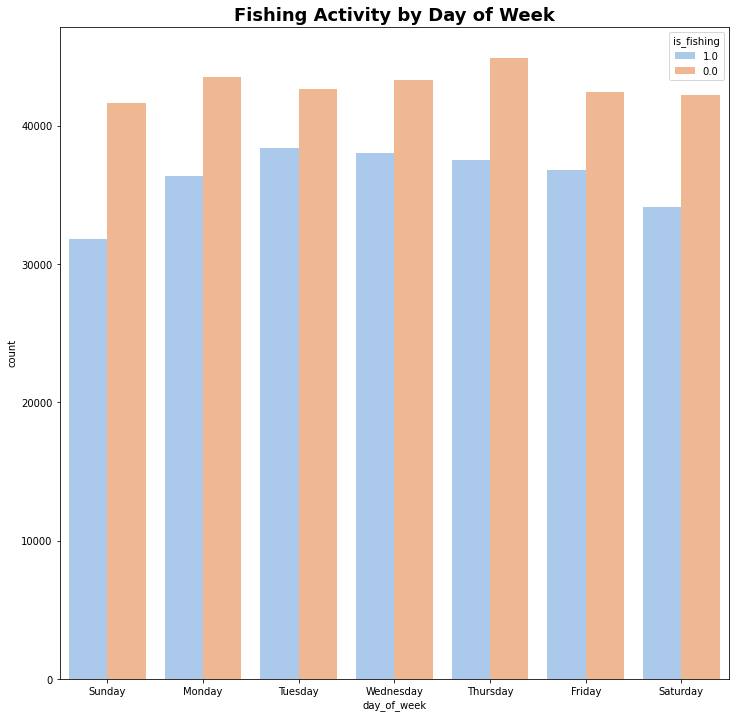

In [507]:
# fishing activity by day of the week 
plt.figure(figsize = (12, 12))
ax = sns.countplot(
    data = train_df, 
    x = 'day_of_week', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    palette = 'pastel'
)
plt.title('Fishing Activity by Day of Week', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Month')

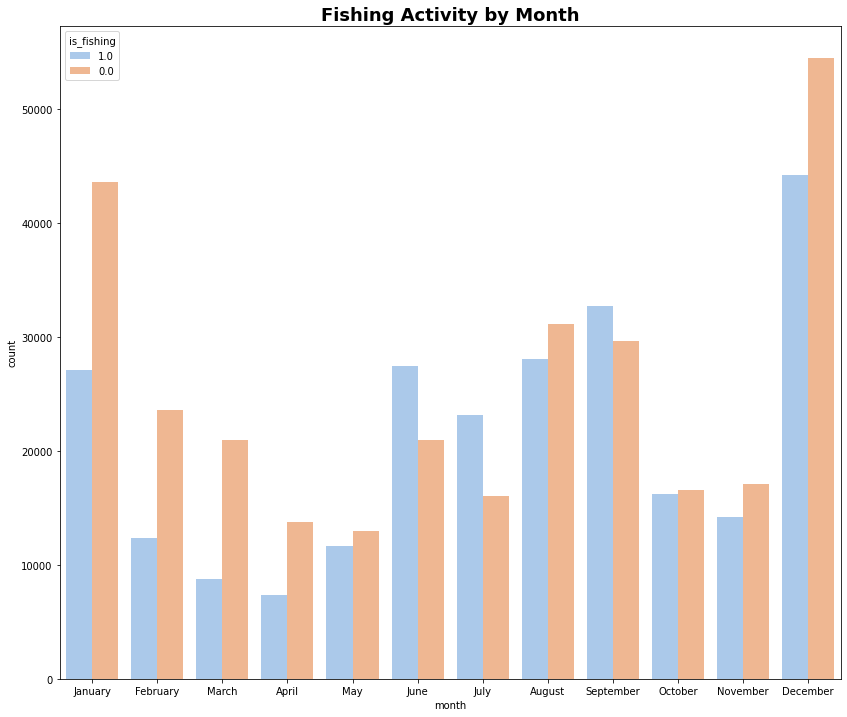

In [508]:
# fishing activity by month 
plt.figure(figsize = (14, 12))
ax = sns.countplot(
    data = train_df, 
    x = 'month', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    palette = 'pastel'
)
plt.title('Fishing Activity by Month', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Hour (24 hour format)')

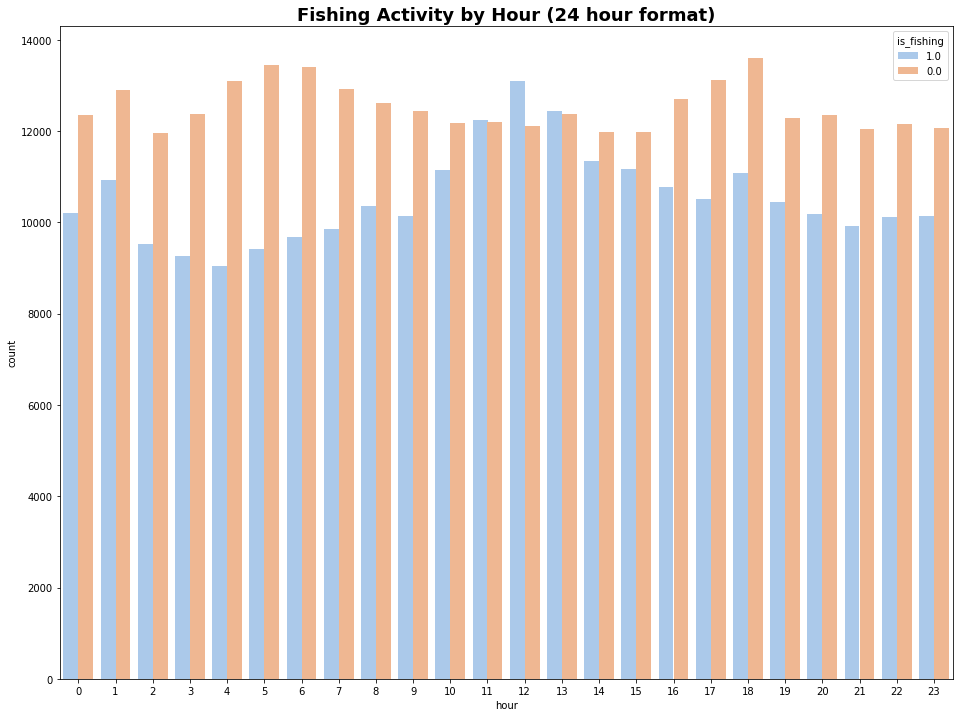

In [509]:
# fishing activity by hour 
plt.figure(figsize = (16, 12))
ax = sns.countplot(
    data = train_df, 
    x = 'hour', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    palette = 'pastel'
)
plt.title('Fishing Activity by Hour (24 hour format)', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Year')

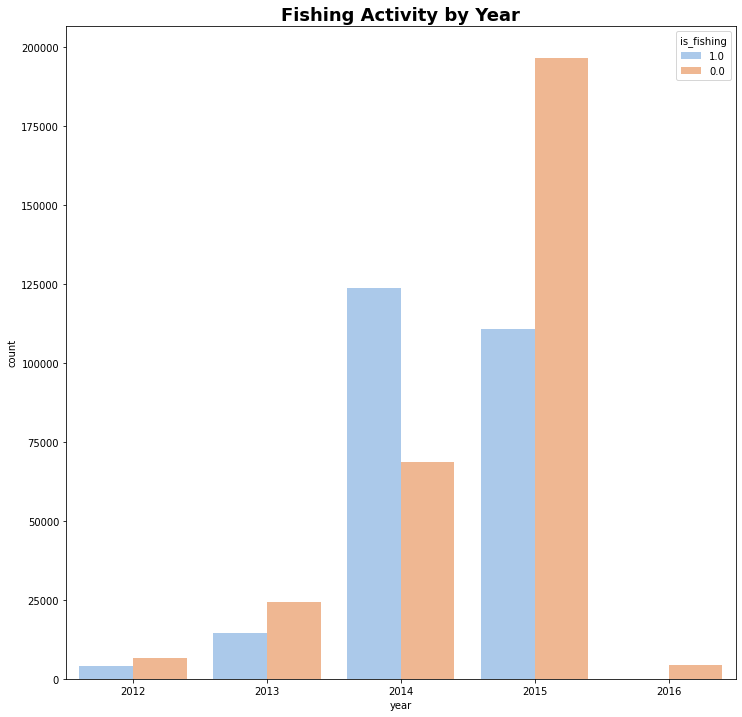

In [510]:
# fishing activity by year 
# this plot doesn't tell us much, sample of data is not representative of all vessels on the water in each year 
plt.figure(figsize = (12, 12))
ax = sns.countplot(
    data = train_df, 
    x = 'year', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = [2012, 2013, 2014, 2015, 2016],
    palette = 'pastel'
)
plt.title('Fishing Activity by Year', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

## Additional Data Wrangling

In [511]:
# drop unneeded columns 
train_df.drop(['mmsi', 'timestamp', 'timestamp_reformat', 'day_of_week', 'month', 'year', 'source', 'fishing_type'], axis = 1, inplace = True)
train_df.head()

,hour,day_of_week_num,month_num,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
330,17,5,6,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,1,0,0,0,0,0,0
423,8,1,6,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,1,0,0,0,0,0,0
570,7,3,8,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,1,0,0,0,0,0,0
638,5,4,8,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,1,0,0,0,0,0,0
677,6,2,9,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,1,0,0,0,0,0,0


In [512]:
# check values of course that are invalid
train_df[train_df['course'] > 360]

,hour,day_of_week_num,month_num,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
515579,1,6,3,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539442,11,1,12,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539448,13,1,12,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539493,1,2,12,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539495,1,2,12,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810720,10,4,12,2236.013184,47295.777344,8.0,511.0,44.689999,14.798333,1.0,0,0,0,0,0,0,1
5810766,22,4,12,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1
5810769,22,4,12,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1
5810776,0,4,12,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1


In [513]:
def fill_course(row):
    '''For each row with invalid course value, find the most similar similar row (through euclidean distance) 
       with a valid course value and take that course value
    '''
    if row['course'] <= 360:
        return row 
    else: 
        ary = scipy.spatial.distance.cdist(train_df[train_df['course'] <= 360], row.to_frame().transpose(), metric = 'euclidean')
        row['course'] = train_df[train_df['course'] <= 360].loc[ary == ary.min()]['course']
        return row

# train_df[train_df['course'] > 360].apply(fill_course, axis = 1)
train_df = train_df.apply(fill_course, axis = 1)

# recheck if any invalid course values are left 
train_df[train_df['course'] > 360]

,hour,day_of_week_num,month_num,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown


In [514]:
# drop 5 rows with NaN course values
train_df = train_df[~train_df['course'].isnull()]
train_df.isnull().sum()

hour                   0
day_of_week_num        0
month_num              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
drifting_long_line     0
fixed_gear             0
pole_line              0
purse_seines           0
trawler                0
troller                0
unknown                0
dtype: int64

In [515]:
train_df['is_fishing'].value_counts()

0.0    300761
1.0    253087
Name: is_fishing, dtype: int64

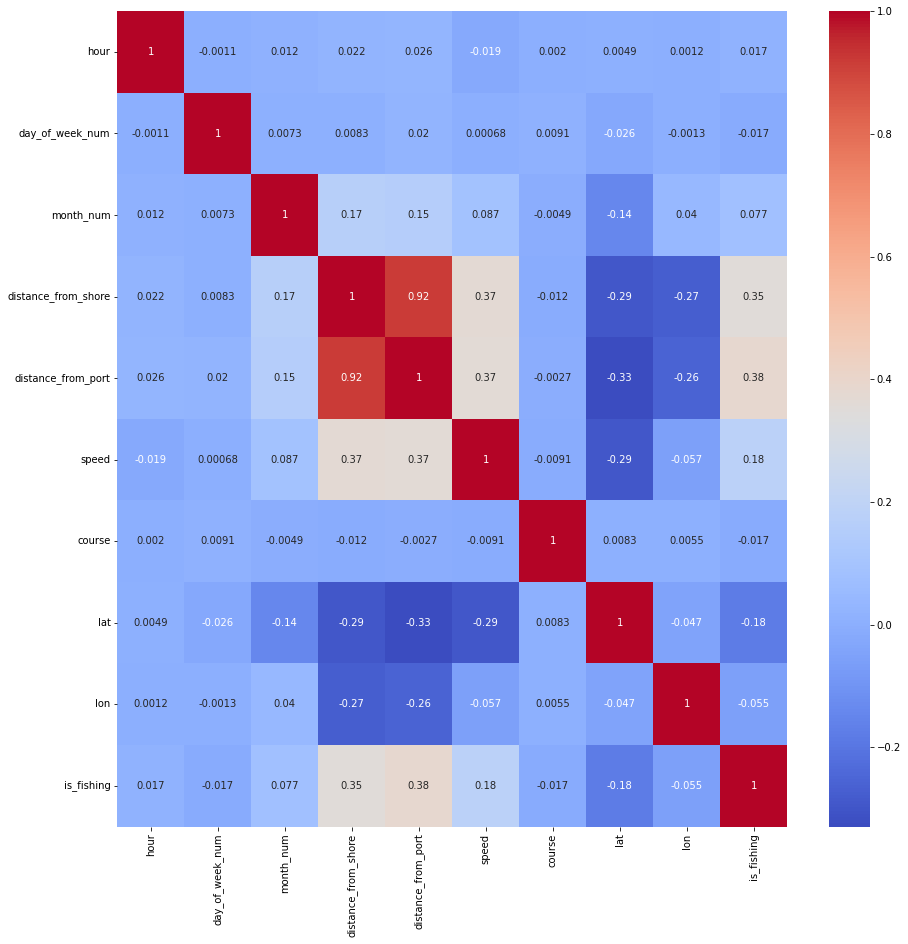

In [516]:
# correlation heatmap
corr_df = train_df.drop(['drifting_long_line', 'fixed_gear', 'pole_line', 'purse_seines', 'trawler', 'troller', 'unknown'], axis = 1).corr()
plt.figure(figsize =(15, 15))
ax = sns.heatmap(corr_df, annot = True, cmap = 'coolwarm')

As seen above distance_from_shroe and distance_from_port are highly correlated with each other. We can drop one of them. We will drop distance_from_shroe.  

In [517]:
train_df.drop('distance_from_shore', axis = 1, inplace = True)

## Split Into Train/Test Sets 

In [518]:
# get x values
x = train_df.drop('is_fishing', axis = 1)
# get labels 
y = train_df['is_fishing']

# split into train/test sets 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8)

In [519]:
# scaled data for logistic regression 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Modeling  
---

## Logistic Regression  
Initial hyperparameter tuning done with randomized search CV. After a good starting point is identified, more focused hyperparameter tuning done using grid search CV. 

In [520]:
# parameter to tune 
c = [x for x in np.logspace(-8, 3, 5000)]

log_reg_random_search_param_grid = {'C': c}

# model
estimator_rcv_log_reg = LogisticRegression()

# random search over the parameters, 5 fold cross validation, __ iterations 
log_reg_random_search = RandomizedSearchCV(estimator = estimator_rcv_log_reg, scoring = 'f1', param_distributions = log_reg_random_search_param_grid, verbose = 2, n_iter = 200, cv = 5)
log_reg_random_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ...........................C=0.00016697233821789386; total time=   0.2s
[CV] END ...........................C=0.00016697233821789386; total time=   0.2s
[CV] END ...........................C=0.00016697233821789386; total time=   0.2s
[CV] END ...........................C=0.00016697233821789386; total time=   0.2s
[CV] END ...........................C=0.00016697233821789386; total time=   0.2s
[CV] END ............................C=0.0030136708624026753; total time=   0.2s
[CV] END ............................C=0.0030136708624026753; total time=   0.2s
[CV] END ............................C=0.0030136708624026753; total time=   0.2s
[CV] END ............................C=0.0030136708624026753; total time=   0.2s
[CV] END ............................C=0.0030136708624026753; total time=   0.2s
[CV] END ............................C=3.829275590127989e-08; total time=   0.2s
[CV] END ............................C=3.8292

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=200,
                   param_distributions={'C': [1e-08, 1.0050795579776502e-08,
                                              1.0101849178645489e-08,
                                              1.0153162107229875e-08,
                                              1.0204735682810032e-08,
                                              1.0256571229357462e-08,
                                              1.0308670077568882e-08,
                                              1.0361033564900361e-08,
                                              1.0413663035601632e-08,
                                              1.0466559840750683e-08,
                                              1.0519725338288322e-08,
                                              1.0573160893053114e-08...
                                              1.0789631224543068e-08,
                                              1.08444377819056e-08,
              

In [521]:
# best parameters found
log_reg_random_search.best_params_['C']

1.682074275381126e-05

In [522]:
# best f1 score
log_reg_random_search.best_score_

0.6481080741966113

In [529]:
# predictions 
log_reg_random_search_preds = log_reg_random_search.predict(x_test_scaled) 

# classification report 
print(classification_report(y_test, log_reg_random_search_preds))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75     60151
         1.0       0.71      0.59      0.65     50619

    accuracy                           0.71    110770
   macro avg       0.71      0.70      0.70    110770
weighted avg       0.71      0.71      0.70    110770



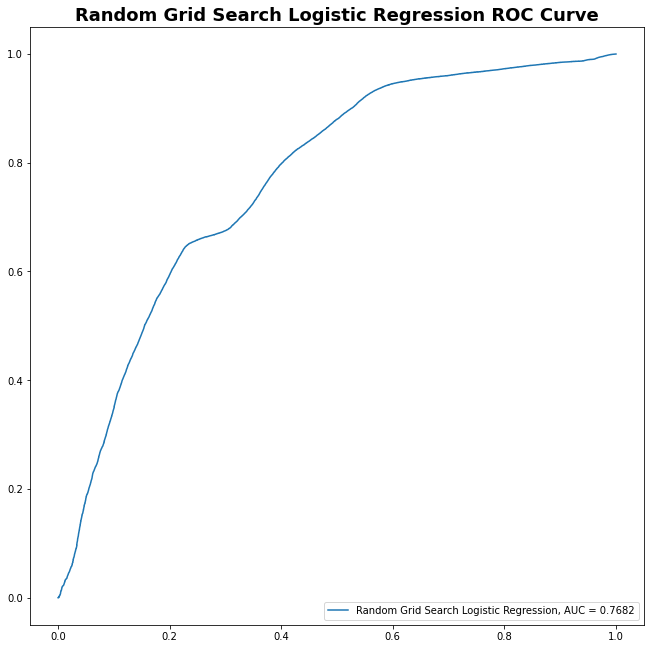

In [540]:
# plot roc curve 
plt.figure(figsize = (11, 11))
log_reg_random_search_preds_prob = log_reg_random_search.predict_proba(x_test_scaled)[::,1]
log_reg_random_search_preds_fpr, log_reg_random_search_preds_tpr, _ = roc_curve(y_test, log_reg_random_search_preds_prob)
log_reg_random_search_auc = round(roc_auc_score(y_test, log_reg_random_search_preds_prob), 4)
plt.plot(log_reg_random_search_preds_fpr, log_reg_random_search_preds_tpr, label = f'Random Grid Search Logistic Regression, AUC = {log_reg_random_search_auc}')
plt.title('Random Grid Search Logistic Regression ROC Curve', fontdict = {'fontsize': 18, 'fontweight': 'bold'})
plt.legend(loc = 'lower right')

Now that we found a good starting point, use grid search CV to search hyperparameters around our starting point. 

In [523]:
# parameter to tune 
c_grid = [x for x in np.linspace(log_reg_random_search.best_params_['C'], log_reg_random_search.best_params_['C'] + 0.005, 300)]

log_reg_grid_search_param_grid = {'C': c_grid}

# model
estimator_gscv_log_reg = LogisticRegression()

# grid search
log_reg_grid_search = GridSearchCV(estimator = estimator_gscv_log_reg, scoring = 'f1', param_grid = log_reg_grid_search_param_grid, cv = 5, verbose = 2)
log_reg_grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END ...........................C=-3.317925724618874e-05; total time=   0.0s
[CV] END ...........................C=-3.317925724618874e-05; total time=   0.0s
[CV] END ...........................C=-3.317925724618874e-05; total time=   0.0s
[CV] END ...........................C=-3.317925724618874e-05; total time=   0.0s
[CV] END ...........................C=-3.317925724618874e-05; total time=   0.0s
[CV] END ..........................C=-1.6289625139165327e-05; total time=   0.0s
[CV] END ..........................C=-1.6289625139165327e-05; total time=   0.0s
[CV] END ..........................C=-1.6289625139165327e-05; total time=   0.0s
[CV] END ..........................C=-1.6289625139165327e-05; total time=   0.0s
[CV] END ..........................C=-1.6289625139165327e-05; total time=   0.0s
[CV] END ............................C=6.000069678580882e-07; total time=   0.2s
[CV] END ............................C=6.0000

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1464, in fit
    raise ValueError("Penalty term must be positive; got (C=%r)" % self.C)
ValueError: Penalty term must be positi

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [-3.317925724618874e-05, -1.6289625139165327e-05,
                               6.000069678580882e-07, 1.7489639074881503e-05,
                               3.437927118190492e-05, 5.1268903288928333e-05,
                               6.815853539595174e-05, 8.504816750297517e-05,
                               0.00010193779960999857, 0.000118827431717022,
                               0.0001357170638240454, 0.0001526066959310688,
                               0.0001694963280...
                               0.00020327559225213906, 0.00022016522435916246,
                               0.0002370548564661859, 0.0002539444885732093,
                               0.00027083412068023275, 0.0002877237527872561,
                               0.00030461338489427955, 0.000321503017001303,
                               0.00033839264910832636, 0.0003552822812153498,
                               0.0003721719

In [524]:
# best parameters found
log_reg_grid_search.best_params_['C']

1.7489639074881503e-05

In [525]:
# best f1 score
log_reg_grid_search.best_score_

0.6481984366985024

In [541]:
# predictions 
log_reg_grid_search_preds = log_reg_grid_search.predict(x_test_scaled)

# classification report
print(classification_report(y_test, log_reg_grid_search_preds))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75     60151
         1.0       0.71      0.59      0.65     50619

    accuracy                           0.71    110770
   macro avg       0.71      0.70      0.70    110770
weighted avg       0.71      0.71      0.70    110770



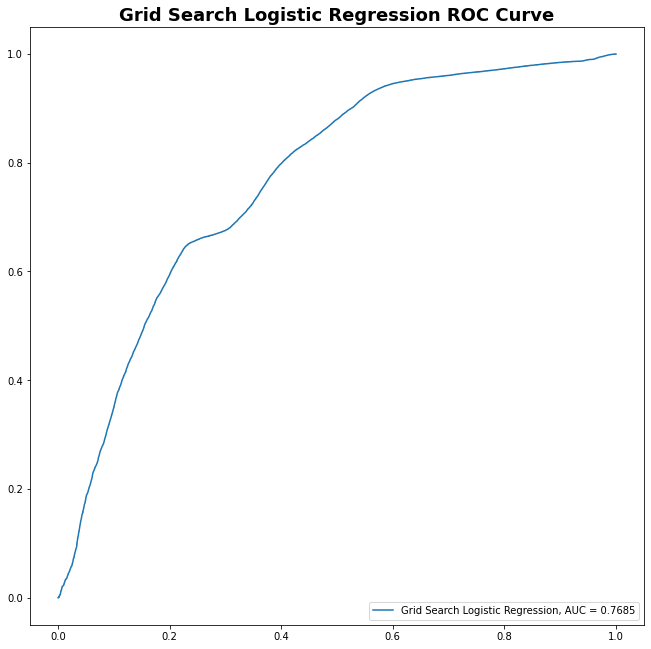

In [542]:
# roc curve
plt.figure(figsize = (11, 11))
log_reg_grid_search_preds_prob = log_reg_grid_search.predict_proba(x_test_scaled)[::,1]
log_reg_grid_search_preds_fpr, log_reg_grid_search_preds_tpr, _ = roc_curve(y_test, log_reg_grid_search_preds_prob)
log_reg_grid_search_auc = round(roc_auc_score(y_test, log_reg_grid_search_preds_prob), 4)
plt.plot(log_reg_grid_search_preds_fpr, log_reg_grid_search_preds_tpr, label = f'Grid Search Logistic Regression, AUC = {log_reg_grid_search_auc}')
plt.title('Grid Search Logistic Regression ROC Curve', fontdict = {'fontsize': 18, 'fontweight': 'bold'})
plt.legend(loc = 'lower right')

## K-Nearest Neighbors

## Neural Network